# Structured Output

In [1]:
import os

import azure.identity
import openai
import rich
from dotenv import load_dotenv
from pydantic import BaseModel, Field

load_dotenv(override=True)
API_HOST = os.getenv("API_HOST", "github")

client = openai.OpenAI(
    base_url="https://models.github.ai/inference",
    api_key=os.environ["GITHUB_TOKEN"],
)

MODEL_NAME = os.getenv("GITHUB_MODEL", "openai/gpt-4o")

In [2]:
# define the schema for the structured output
class CalendarEvent(BaseModel):
    name: str
    date: str = Field(..., description="A date in the format YYYY-MM-DD") #it is recommended to add description for better parsing
    participants: list[str]


completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {
            "role": "system",
            "content": "Extract the event information. If no year is specified, assume the current year (2025).",
        },
        {"role": "user", "content": "Alice and Bob are going to a science fair on the 1st of april."},
    ],
    response_format=CalendarEvent,
)

In [ ]:
message = completion.choices[0].message
# check if it's able to adhere to the schema
if message.refusal:
    rich.print(message.refusal)
else:
    event = message.parsed
    rich.print(event)
    
    print(f"Event Name: {event.name}")
    print(f"Event Date: {event.date}")
    print(f"Participants: {', '.join(event.participants)}")

CalendarEvent(name='Science Fair', date='2025-04-01', participants=['Alice', 'Bob'])

Event Name: Science Fair
Event Date: 2025-04-01
Participants: Alice, Bob


## With Enum

In [4]:
from enum import Enum

In [5]:
class DayOfWeek(str, Enum):
    SUNDAY = "Sunday"
    MONDAY = "Monday"
    TUESDAY = "Tuesday"
    WEDNESDAY = "Wednesday"
    THURSDAY = "Thursday"
    FRIDAY = "Friday"
    SATURDAY = "Saturday"


class CalendarEvent(BaseModel):
    name: str
    date: DayOfWeek
    participants: list[str]

In [6]:
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice and Bob are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)


message = completion.choices[0].message
if message.refusal:
    rich.print(message.refusal)
else:
    event = message.parsed
    rich.print(event)
    print(event.date.value)  # Access the enum value

CalendarEvent(name='Science Fair', date=<DayOfWeek.FRIDAY: 'Friday'>, participants=['Alice', 'Bob'])

Friday


## Nested data models

In [ ]:
class Participant(BaseModel):
    name: str
    job_title: str


class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[Participant] #nested

In [8]:
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {"role": "user", "content": "Alice the carpenter and Bob the plumber are going to a science fair on Friday."},
    ],
    response_format=CalendarEvent,
)


message = completion.choices[0].message
if message.refusal:
    rich.print(message.refusal)
else:
    event = message.parsed
    rich.print(event)

CalendarEvent(
    name='Science Fair',
    date='Friday',
    participants=[Participant(name='Alice', job_title='Carpenter'), Participant(name='Bob', job_title='Plumber')]
)

## Structured output scenarios

1. Entity extraction

    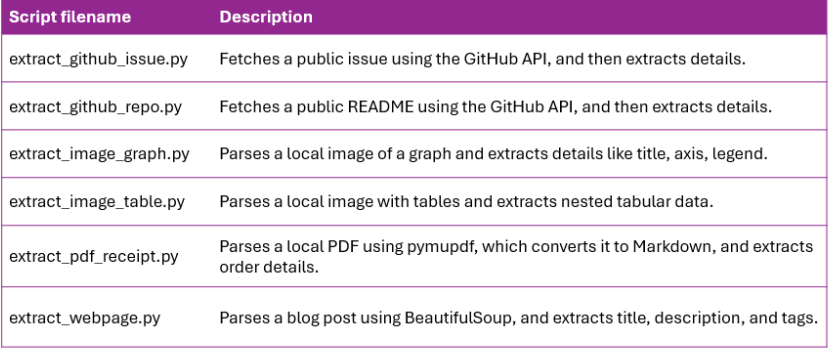
    https://github.com/Azure-Samples/azure-openai-entity-extraction/
2. Classification
3. OCR (optical character recognition) with vision models

### Entity extraction: GitHub issues

extract a summarised description of the issues of the repo

In [ ]:
import logging
import requests
from rich import print

logging.basicConfig(level=logging.WARNING)

In [21]:
# Define models for Structured Outputs
class IssueType(str, Enum):
    BUGREPORT = "Bug Report"
    FEATURE = "Feature"
    DOCUMENTATION = "Documentation"
    REGRESSION = "Regression"


class Issue(BaseModel):
    title: str
    description: str = Field(..., description="A 1-2 sentence description of the project")
    type: IssueType
    operating_system: str

In [23]:
# Fetch an issue from a public GitHub repository
url = "https://api.github.com/repos/Azure-Samples/azure-search-openai-demo/issues/2231"
response = requests.get(url)
if response.status_code != 200:
    logging.error(f"Failed to fetch issue: {response.status_code}")
    exit(1)
issue_body = response.json()["body"]

In [24]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the info from the GitHub issue markdown."},
        {"role": "user", "content": issue_body},
    ],
    response_format=Issue,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

Issue(
    title="Metadata 'groups' field not populating correctly during deployment.",
    description='The issue arises when deploying an app with specific configurations leading to metadata not being 
set appropriately.',
    type=<IssueType.BUGREPORT: 'Bug Report'>,
    operating_system='win 10'
)

### Entity extraction: GitHub repo readme

In [30]:
import base64

In [31]:
# Define models for Structured Outputs
class Language(str, Enum):
    JAVASCRIPT = "JavaScript"
    PYTHON = "Python"
    DOTNET = ".NET"


class AzureService(str, Enum):
    AISTUDIO = "AI Studio"
    AISEARCH = "AI Search"
    POSTGRESQL = "PostgreSQL"
    COSMOSDB = "CosmosDB"
    AZURESQL = "Azure SQL"


class Framework(str, Enum):
    LANGCHAIN = "Langchain"
    SEMANTICKERNEL = "Semantic Kernel"
    LLAMAINDEX = "Llamaindex"
    AUTOGEN = "Autogen"
    SPRINGBOOT = "Spring Boot"
    PROMPTY = "Prompty"


class RepoOverview(BaseModel):
    name: str
    description: str = Field(..., description="A 1-2 sentence description of the project")
    languages: list[Language]
    azure_services: list[AzureService]
    frameworks: list[Framework]

In [32]:
# Fetch a README from a public GitHub repository
url = "https://api.github.com/repos/shank250/CareerCanvas-msft-raghack/contents/README.md"
response = requests.get(url)
if response.status_code != 200:
    logging.error(f"Failed to fetch issue: {response.status_code}")
    exit(1)
content = response.json()
readme_content = base64.b64decode(content["content"]).decode("utf-8")

In [34]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {
            "role": "system",
            "content": "Extract the information from the GitHub issue markdown about this hack submission.",
        },
        {"role": "user", "content": readme_content},
    ],
    response_format=RepoOverview,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

RepoOverview(
    name='Job Finder Chatbot',
    description='A chatbot system assisting users in job search leveraging RAG for personalized recommendations 
using Azure services.',
    languages=[<Language.JAVASCRIPT: 'JavaScript'>],
    azure_services=[
        <AzureService.AISTUDIO: 'AI Studio'>,
        <AzureService.AISEARCH: 'AI Search'>,
        <AzureService.POSTGRESQL: 'PostgreSQL'>
    ],
    frameworks=[<Framework.SPRINGBOOT: 'Spring Boot'>]
)

### Entity extraction : Webpages

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
# Define models for Structured Outputs
class BlogPost(BaseModel):
    title: str
    summary: str = Field(..., description="A 1-2 sentence summary of the blog post")
    tags: list[str] = Field(..., description="A list of tags for the blog post, like 'python' or 'openai'")

In [ ]:
# Fetch blog post and extract title/content
url = "https://blog.pamelafox.org/2024/09/integrating-vision-into-rag-applications.html"
response = requests.get(url)
if response.status_code != 200:
    print(f"Failed to fetch the page: {response.status_code}")
    exit(1)
soup = BeautifulSoup(response.content, "html.parser")
post_title = soup.find("h3", class_="post-title")
post_contents = soup.find("div", class_="post-body").get_text(strip=True)

In [ ]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the information from the blog post"},
        {"role": "user", "content": f"{post_title}\n{post_contents}"},
    ],
    response_format=BlogPost,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

BlogPost(
    title='Integrating Vision into RAG Applications',
    summary="This blog post explores the integration of multimodal capabilities, including image understanding, 
into Retrieval Augmented Generation (RAG) applications, specifically using Azure's AI services to enhance data 
retrieval and question-answering functionalities.",
    tags=['RAG', 'Microsoft Azure', 'AI', 'GPT-4', 'Vision']
)

### Entity extraction : PDFs

In [35]:
import pymupdf4llm

Consider using the pymupdf_layout package for a greatly improved page layout analysis.


In [36]:
# Define models for Structured Outputs
class Item(BaseModel):
    product: str
    price: float
    quantity: int


class Receipt(BaseModel):
    total: float
    shipping: float
    payment_method: str
    items: list[Item]
    order_number: int


In [37]:
# Prepare PDF as markdown text
md_text = pymupdf4llm.to_markdown("example_receipt.pdf")

In [38]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the information from the receipt"},
        {"role": "user", "content": md_text},
    ],
    response_format=Receipt,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

Receipt(
    total=242.05,
    shipping=0.0,
    payment_method='Credit Card',
    items=[
        Item(
            product='Die Cut ID: 158484 • 3 × 3 • Lamination: Glossy • Shape: Contour',
            price=242.05,
            quantity=500
        )
    ],
    order_number=123456
)

### Entity extraction : MS Office Documents

In [53]:
from markitdown import MarkItDown

In [54]:
# Define models for Structured Outputs
class DocumentMetadata(BaseModel):
    title: str
    author: str | None
    headings: list[str]

In [ ]:
# Use markitdown to convert docx to markdown
md = MarkItDown(enable_plugins=False)
markdown_text = md.convert("example_doc.docx").text_content

FileConversionException: File conversion failed after 1 attempts:
 - DocxConverter threw MissingDependencyException with message: DocxConverter recognized the input as a potential .docx file, but the dependencies needed to read .docx files have not been installed. To resolve this error, include the optional dependency [docx] or [all] when installing MarkItDown. For example:

* pip install markitdown[docx]
* pip install markitdown[all]
* pip install markitdown[docx, ...]
* etc.


In [63]:
# Send request to LLM to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the document title, author, and a list of all headings."},
        {"role": "user", "content": markdown_text},
    ],
    response_format=DocumentMetadata,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

NameError: name 'markdown_text' is not defined

### Entity extraction : Image

In [56]:
# Define models for Structured Outputs
class Graph(BaseModel):
    title: str
    description: str = Field(..., description="1 sentence description of the graph")
    x_axis: str
    y_axis: str
    legend: list[str]


# Prepare local image as base64 URI
def open_image_as_base64(filename):
    with open(filename, "rb") as image_file:
        image_data = image_file.read()
    image_base64 = base64.b64encode(image_data).decode("utf-8")
    return f"data:image/png;base64,{image_base64}"

In [57]:
image_url = open_image_as_base64("example_graph_treecover.png")

In [58]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the information from the graph"},
        {
            "role": "user",
            "content": [
                {"image_url": {"url": image_url}, "type": "image_url"},
            ],
        },
    ],
    response_format=Graph,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

Graph(
    title='Global tree cover: annual loss',
    description='This graph illustrates the annual loss of tree cover globally, categorized by region from 2000 to 
recent years.',
    x_axis='Year',
    y_axis='Loss (Thousand square kilometers/miles)',
    legend=['Boreal', 'Temperate', 'Subtropical', 'Tropical']
)

### Entity extraction : Image with tables

In [59]:
# Define models for Structured Outputs
class Plant(BaseModel):
    species: str
    common_name: str
    quantity: int
    size: str
    price: float
    county: str
    notes: str


class PlantInventory(BaseModel):
    annuals: list[Plant]
    bulbs: list[Plant]
    grasses: list[Plant]


# Prepare local image as base64 URI
def open_image_as_base64(filename):
    with open(filename, "rb") as image_file:
        image_data = image_file.read()
    image_base64 = base64.b64encode(image_data).decode("utf-8")
    return f"data:image/png;base64,{image_base64}"

In [60]:
image_url = open_image_as_base64("example_table_plants.png")

In [61]:
# Send request to GPT model to extract using Structured Outputs
completion = client.beta.chat.completions.parse(
    model=MODEL_NAME,
    messages=[
        {"role": "system", "content": "Extract the information from the table"},
        {
            "role": "user",
            "content": [
                {"image_url": {"url": image_url}, "type": "image_url"},
            ],
        },
    ],
    response_format=PlantInventory,
)

message = completion.choices[0].message
if message.refusal:
    print(message.refusal)
else:
    print(message.parsed)

PlantInventory(
    annuals=[
        Plant(
            species='Centromadia pungens',
            common_name='Common tarweed',
            quantity=8,
            size="4''s",
            price=1.83,
            county='Unknown',
            notes='75% off sale'
        ),
        Plant(
            species='Epilobium densiflorum',
            common_name='Dense Spike-primrose',
            quantity=3,
            size="4''s",
            price=3.65,
            county='San Mateo',
            notes='50% off sale'
        ),
        Plant(
            species='Eschscholzia caespitosa',
            common_name='Tufted Poppy',
            quantity=119,
            size='D-16S',
            price=3.6,
            county='Unknown',
            notes='50% off sale'
        ),
        Plant(
            species='Eschscholzia californica',
            common_name='California poppy',
            quantity=85,
            size='D-16S',
            price=3.6,
            county='Bay Area',
            notes='50% off sale'
        ),
        Plant(
            species="Eschscholzia californica 'Purple Gleam'",
            common_name='Purple Gleam Poppy',
            quantity=2,
            size='D-16S',
            price=3.6,
            county='Unknown',
            notes='50% off sale'
        ),
        Plant(
            species='Eschscholzia californica var. maritima',
            common_name='Coastal California Poppy',
            quantity=137,
            size='D-16S',
            price=3.6,
            county='Unknown',
            notes='50% off sale'
        ),
        Plant(
            species='Madia elegans',
            common_name='Tarweed',
            quantity=6,
            size="4''s",
            price=1.83,
            county='Unknown',
            notes='75% off sale'
        ),
        Plant(
            species='Mentzelia lindleyi',
            common_name="Lindley's Blazing Star",
            quantity=35,
            size="4''s",
            price=3.65,
            county='Unknown',
            notes='50% off sale'
        ),
        Plant(
            species='Symphyotrichum subulatum',
            common_name='Slim marsh aster',
            quantity=10,
            size='D-16S',
            price=5.4,
            county='Contra Costa',
            notes='25% off sale'
        ),
        Plant(
            species='Trichostema lanceolatum',
            common_name='Vinegar weed',
            quantity=11,
            size='D-16S',
            price=5.4,
            county='Contra Costa',
            notes='25% off sale'
        ),
        Plant(
            species='Trichostema lanceolatum',
            common_name='Vinegar weed',
            quantity=20,
            size='D-16S',
            price=5.4,
            county='Stanislaus',
            notes='25% off sale'
        )
    ],
    bulbs=[
        Plant(
            species='Brodiaea californica',
            common_name='California brodiaea',
            quantity=31,
            size='D-16',
            price=7.3,
            county='Bay Area',
            notes=''
        ),
        Plant(
            species='Chlorogalum pomeridianum',
            common_name='Soap plant',
            quantity=20,
            size='1-Gal',
            price=15.7,
            county='E. Marin',
            notes=''
        ),
        Plant(
            species='Epipactis gigantea',
            common_name='Stream orchid',
            quantity=19,
            size='1-Gal',
            price=15.7,
            county='Unknown',
            notes=''
        ),
        Plant(
            species='Wyethia angustifolia',
            common_name='Narrowleaf mule ears',
            quantity=31,
            size='D-16',
            price=7.3,
            county='Marin',
            notes=''
        ),
        Plant(
            species='Wyethia angustifolia',
            common_name='Narrowleaf mule ears',
            quantity=43,
            size='D-16',
            price=7.3,